<a href="https://colab.research.google.com/github/1989-juliana-h/hello-world/blob/master/Test_Text_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
text_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Beispieldaten_Krankenkassen-Bewertungen.csv")

In [9]:
text_df.head()

,Bewertungs_ID,Kunde_Alter,Kunde_Geschlecht,Bewertung_Text,Sterne
0,1,22,w,Sehr schnelle Rückmeldung per Telefon und E-Mail.,2
1,2,35,w,Die Bearbeitung meiner Rechnung hat viel zu la...,5
2,3,22,d,"Ich bin sehr zufrieden, fühle mich gut aufgeho...",1
3,4,22,w,"Ich musste mehrfach nachhaken, bis mein Antrag...",2
4,5,68,d,"Sehr freundlicher Kundenservice, mir wurde sof...",5


### Text Preprocessing

First, we'll clean the 'Bewertung_Text' column by removing special characters, punctuation, and converting the text to lowercase.

In [10]:
import re
import string

def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    return text

text_df['Cleaned_Bewertung_Text'] = text_df['Bewertung_Text'].apply(preprocess_text)

display(text_df[['Bewertung_Text', 'Cleaned_Bewertung_Text']].head())

,Bewertung_Text,Cleaned_Bewertung_Text
0,Sehr schnelle Rückmeldung per Telefon und E-Mail.,sehr schnelle rückmeldung per telefon und email
1,Die Bearbeitung meiner Rechnung hat viel zu la...,die bearbeitung meiner rechnung hat viel zu la...
2,"Ich bin sehr zufrieden, fühle mich gut aufgeho...",ich bin sehr zufrieden fühle mich gut aufgehoben
3,"Ich musste mehrfach nachhaken, bis mein Antrag...",ich musste mehrfach nachhaken bis mein antrag ...
4,"Sehr freundlicher Kundenservice, mir wurde sof...",sehr freundlicher kundenservice mir wurde sofo...


### Tokenization

Next, we will tokenize the cleaned text, which means splitting the text into individual words or tokens. We will also remove stop words (common words like "the", "a", "is") as they usually don't carry much meaning for analysis.

In [30]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download necessary NLTK data (if not already downloaded)
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')


stop_words = set(stopwords.words('german')) # Using German stop words
# Add more custom stop words based on previous observation
custom_stop_words = ['wurde', 'haben', 'sein', 'können', 'müssen', 'sollen', 'werden', 'gibt', 'hatte', 'wären'] # Added more common words
stop_words.update(custom_stop_words)

def tokenize_text(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words] # Remove stop words
    return tokens

text_df['Tokens'] = text_df['Cleaned_Bewertung_Text'].apply(tokenize_text)

display(text_df[['Cleaned_Bewertung_Text', 'Tokens']].head())

,Cleaned_Bewertung_Text,Tokens
0,sehr schnelle rückmeldung per telefon und email,"[schnelle, rückmeldung, per, telefon, email]"
1,die bearbeitung meiner rechnung hat viel zu la...,"[bearbeitung, rechnung, lange, gedauert]"
2,ich bin sehr zufrieden fühle mich gut aufgehoben,"[zufrieden, fühle, gut, aufgehoben]"
3,ich musste mehrfach nachhaken bis mein antrag ...,"[mehrfach, nachhaken, antrag, bearbeitet]"
4,sehr freundlicher kundenservice mir wurde sofo...,"[freundlicher, kundenservice, sofort, geholfen]"


### Sentiment Analysis

Now, let's perform sentiment analysis to determine whether the reviews are positive, negative, or neutral. We can use a pre-trained model for this.

In [14]:
from transformers import pipeline

# Load a pre-trained sentiment analysis model that supports German
try:
    sentiment_analyzer = pipeline("sentiment-analysis", model="oliverguhr/german-sentiment-bert")
except Exception as e:
    print(f"Could not load sentiment analysis model. Please check your internet connection or try a different model. Error: {e}")
    sentiment_analyzer = None

if sentiment_analyzer:
    # Apply sentiment analysis
    # Note: This can take some time depending on the number of reviews and the model.
    # We'll apply it to a sample for demonstration.
    # For the full dataset, consider processing in batches or using a GPU.
    sample_reviews = text_df['Cleaned_Bewertung_Text'].tolist()[:100] # Analyze a sample
    sentiment_results = sentiment_analyzer(sample_reviews)

    # Map sentiment labels to the DataFrame (for the sample)
    sentiment_labels = [result['label'] for result in sentiment_results]
    # Since we analyzed a sample, we'll create a new column for the sample results
    text_df['Sentiment_Sample'] = None
    text_df.loc[:len(sample_reviews)-1, 'Sentiment_Sample'] = sentiment_labels


    display(text_df[['Cleaned_Bewertung_Text', 'Sentiment_Sample']].head())
else:
    print("Sentiment analysis skipped due to model loading error.")

Device set to use cpu


,Cleaned_Bewertung_Text,Sentiment_Sample
0,sehr schnelle rückmeldung per telefon und email,positive
1,die bearbeitung meiner rechnung hat viel zu la...,negative
2,ich bin sehr zufrieden fühle mich gut aufgehoben,positive
3,ich musste mehrfach nachhaken bis mein antrag ...,negative
4,sehr freundlicher kundenservice mir wurde sofo...,positive


### Topic Modeling

Topic modeling can help us discover the underlying themes or topics present in the reviews. We can use techniques like Latent Dirichlet Allocation (LDA).

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Join tokens back into strings for topic modeling
text_df['Tokens_String'] = text_df['Tokens'].apply(lambda tokens: ' '.join(tokens))

# Create a document-term matrix
# Adjust max_df and min_df based on your corpus size and desired topic granularity
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words=list(stop_words))
dtm = vectorizer.fit_transform(text_df['Tokens_String'])

# Apply LDA
# Adjust n_components based on how many topics you expect
try:
    lda = LatentDirichletAllocation(n_components=5, random_state=42)
    lda.fit(dtm)

    # Function to display topics
    def display_topics(model, feature_names, no_top_words):
        for topic_idx, topic in enumerate(model.components_):
            print(f"Topic {topic_idx}:")
            print(" ".join([feature_names[i]
                            for i in topic.argsort()[:-no_top_words - 1:-1]]))

    # Display the top words for each topic
    no_top_words = 5 # Reduced the number of top words displayed
    display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)

except ValueError as e:
    print(f"Could not perform Topic Modeling. This might happen if the vocabulary size is too small. Error: {e}")
except Exception as e:
    print(f"An error occurred during Topic Modeling: {e}")

Topic 0:
wurde bearbeitet nachhaken mehrfach antrag
Topic 1:
lange gedauert rechnung bearbeitung gut
Topic 2:
schnelle absolut service super abwicklung
Topic 3:
email per rückmeldung telefon ewig
Topic 4:
website richtigen schwer unübersichtliche formulare


### Keyword Extraction

We can extract keywords or important phrases from the reviews using techniques like TF-IDF (Term Frequency-Inverse Document Frequency).

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Use the cleaned text for TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=list(stop_words))
tfidf_matrix = tfidf_vectorizer.fit_transform(text_df['Tokens_String']) # Using Tokens_String from Topic Modeling step

# Get feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Function to get top TF-IDF scores and words for a document
def get_top_tfidf(row, feature_names, top_n=5):
    # Ensure row is in a sparse format that supports iteration over non-zero elements
    if not isinstance(row, np.ndarray):
      row = row.toarray().flatten()

    tfidf_scores = [(feature_names[i], row[i]) for i in row.argsort()[-top_n:] if row[i] > 0]
    sorted_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
    return sorted_scores

# Get top keywords for each review and add to DataFrame
text_df['Top_Keywords'] = text_df.apply(lambda row: get_top_tfidf(tfidf_matrix[row.name], feature_names), axis=1)


display(text_df[['Cleaned_Bewertung_Text', 'Top_Keywords']].head())

# Keep the printing of top keywords for the first few reviews as it's helpful
print("\nTop keywords for the first 5 reviews (word, score):")
for i in range(5):
    print(f"Review {i+1}: {get_top_tfidf(tfidf_matrix[i], feature_names)}")

,Cleaned_Bewertung_Text,Top_Keywords
0,sehr schnelle rückmeldung per telefon und email,"[(telefon, 0.4648846861284211), (rückmeldung, ..."
1,die bearbeitung meiner rechnung hat viel zu la...,"[(rechnung, 0.5420831471117753), (bearbeitung,..."
2,ich bin sehr zufrieden fühle mich gut aufgehoben,"[(fühle, 0.5), (aufgehoben, 0.5), (gut, 0.5), ..."
3,ich musste mehrfach nachhaken bis mein antrag ...,"[(mehrfach, 0.4529076198176561), (nachhaken, 0..."
4,sehr freundlicher kundenservice mir wurde sofo...,"[(wurde, 1.0)]"



Top keywords for the first 5 reviews (word, score):
Review 1: [('telefon', np.float64(0.4648846861284211)), ('rückmeldung', np.float64(0.4648846861284211)), ('per', np.float64(0.4648846861284211)), ('email', np.float64(0.4648846861284211)), ('schnelle', np.float64(0.3681425191595203))]
Review 2: [('rechnung', np.float64(0.5420831471117753)), ('bearbeitung', np.float64(0.5420831471117753)), ('lange', np.float64(0.4775079140093931)), ('gedauert', np.float64(0.42927603624379596))]
Review 3: [('fühle', np.float64(0.5)), ('aufgehoben', np.float64(0.5)), ('gut', np.float64(0.5)), ('zufrieden', np.float64(0.5))]
Review 4: [('mehrfach', np.float64(0.4529076198176561)), ('nachhaken', np.float64(0.4529076198176561)), ('bearbeitet', np.float64(0.4529076198176561)), ('antrag', np.float64(0.4529076198176561)), ('wurde', np.float64(0.4236729300349765))]
Review 5: [('wurde', np.float64(1.0))]


### Word Frequency Analysis

Finally, let's analyze the frequency of words to identify the most common terms used in the reviews after removing stop words.

In [26]:
from collections import Counter

# Flatten the list of tokens
all_tokens = [token for tokens_list in text_df['Tokens'] for token in tokens_list]

# Count word frequencies
word_counts = Counter(all_tokens)

# Display the most common words
print("Most common words:")
for word, count in word_counts.most_common(20): # Display top 20 most common words
    print(f"{word}: {count}")

Most common words:
schnelle: 8
gedauert: 8
lange: 6
wurde: 5
rückmeldung: 4
per: 4
telefon: 4
email: 4
bearbeitung: 4
rechnung: 4
mehrfach: 4
nachhaken: 4
antrag: 4
bearbeitet: 4
super: 4
service: 4
abwicklung: 4
absolut: 4
empfehlenswert: 4
erstattung: 4


### Visualize Keyword Importance with a Word Cloud

Let's create a word cloud to visualize the most important keywords across all reviews. We'll use the TF-IDF scores to determine the size of the words in the cloud.

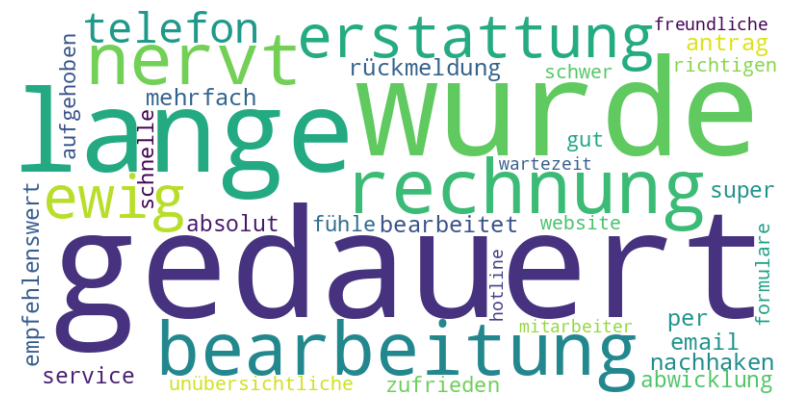

In [29]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all top keywords and their scores
all_keywords = {}
for keyword_list in text_df['Top_Keywords']:
    for word, score in keyword_list:
        if word in all_keywords:
            all_keywords[word] += score
        else:
            all_keywords[word] = score

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(all_keywords)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [27]:
## In der vorgeschlagenen Auswertung von Gemini fällt jetzt auf, dass viele Wörter weniger brauchbar sind, daher sollte man hier zum Beispiel bestimmte Wörter der deutschen Sprache vorab entfernen

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Use the cleaned text for TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=list(stop_words))
tfidf_matrix = tfidf_vectorizer.fit_transform(text_df['Tokens_String']) # Using Tokens_String from Topic Modeling step

# Get feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Function to get top TF-IDF scores and words for a document
def get_top_tfidf(row, feature_names, top_n=5):
    # Ensure row is in a sparse format that supports iteration over non-zero elements
    if not isinstance(row, np.ndarray):
      row = row.toarray().flatten()

    tfidf_scores = [(feature_names[i], row[i]) for i in row.argsort()[-top_n:] if row[i] > 0]
    sorted_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
    return sorted_scores

# Get top keywords for each review and add to DataFrame
text_df['Top_Keywords'] = text_df.apply(lambda row: get_top_tfidf(tfidf_matrix[row.name], feature_names), axis=1)


display(text_df[['Cleaned_Bewertung_Text', 'Top_Keywords']].head())

# Keep the printing of top keywords for the first few reviews as it's helpful
print("\nTop keywords for the first 5 reviews (word, score):")
for i in range(5):
    print(f"Review {i+1}: {get_top_tfidf(tfidf_matrix[i], feature_names)}")

,Cleaned_Bewertung_Text,Top_Keywords
0,sehr schnelle rückmeldung per telefon und email,"[(email, 0.4648846861284211), (telefon, 0.4648..."
1,die bearbeitung meiner rechnung hat viel zu la...,"[(bearbeitung, 0.5420831471117753), (rechnung,..."
2,ich bin sehr zufrieden fühle mich gut aufgehoben,"[(gut, 0.5), (fühle, 0.5), (aufgehoben, 0.5), ..."
3,ich musste mehrfach nachhaken bis mein antrag ...,"[(antrag, 0.5), (mehrfach, 0.5), (nachhaken, 0..."
4,sehr freundlicher kundenservice mir wurde sofo...,[]



Top keywords for the first 5 reviews (word, score):
Review 1: [('email', np.float64(0.4648846861284211)), ('telefon', np.float64(0.4648846861284211)), ('rückmeldung', np.float64(0.4648846861284211)), ('per', np.float64(0.4648846861284211)), ('schnelle', np.float64(0.3681425191595203))]
Review 2: [('bearbeitung', np.float64(0.5420831471117753)), ('rechnung', np.float64(0.5420831471117753)), ('lange', np.float64(0.4775079140093931)), ('gedauert', np.float64(0.42927603624379596))]
Review 3: [('gut', np.float64(0.5)), ('fühle', np.float64(0.5)), ('aufgehoben', np.float64(0.5)), ('zufrieden', np.float64(0.5))]
Review 4: [('antrag', np.float64(0.5)), ('mehrfach', np.float64(0.5)), ('nachhaken', np.float64(0.5)), ('bearbeitet', np.float64(0.5))]
Review 5: []


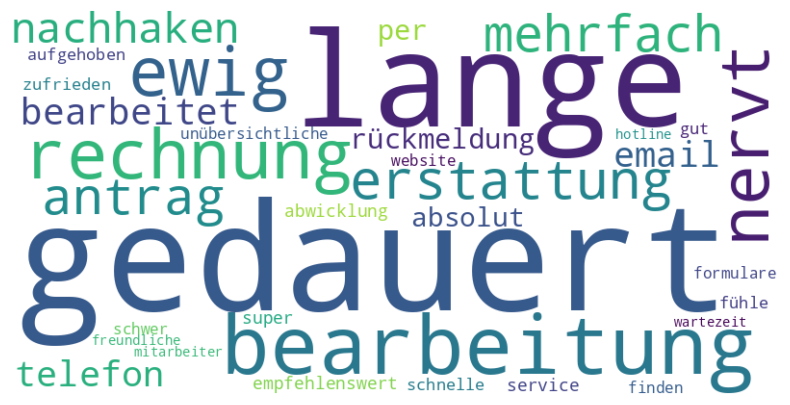

In [33]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all top keywords and their scores
all_keywords = {}
for keyword_list in text_df['Top_Keywords']:
    for word, score in keyword_list:
        if word in all_keywords:
            all_keywords[word] += score
        else:
            all_keywords[word] = score

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(all_keywords)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Word Cloud for Positive Reviews

Let's create a word cloud specifically for reviews that were classified as positive by the sentiment analysis.

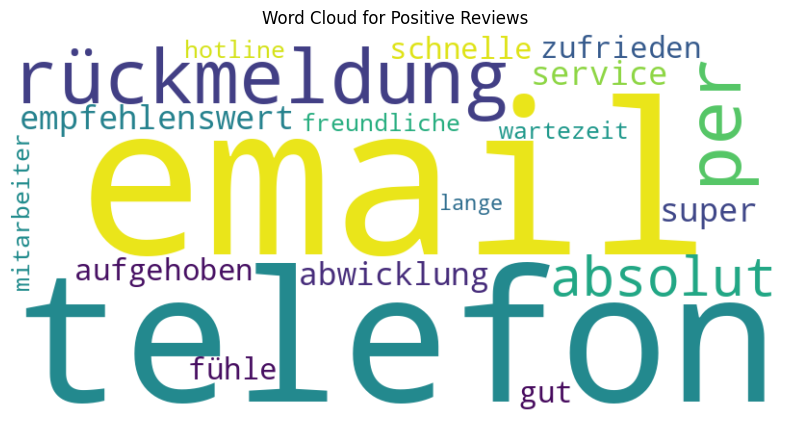

In [35]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter for positive reviews (using the 'Sentiment_Sample' column)
positive_reviews_df = text_df[text_df['Sentiment_Sample'] == 'positive'].copy()

# Combine all top keywords and their scores for positive reviews
positive_keywords = {}
for keyword_list in positive_reviews_df['Top_Keywords']:
    for word, score in keyword_list:
        if word in positive_keywords:
            positive_keywords[word] += score
        else:
            positive_keywords[word] = score

# Generate a word cloud for positive reviews
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(positive_keywords)

# Display the word cloud for positive reviews
plt.figure(figsize=(10, 5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

### Word Cloud for Negative Reviews

Now, let's create a word cloud specifically for reviews that were classified as negative by the sentiment analysis.

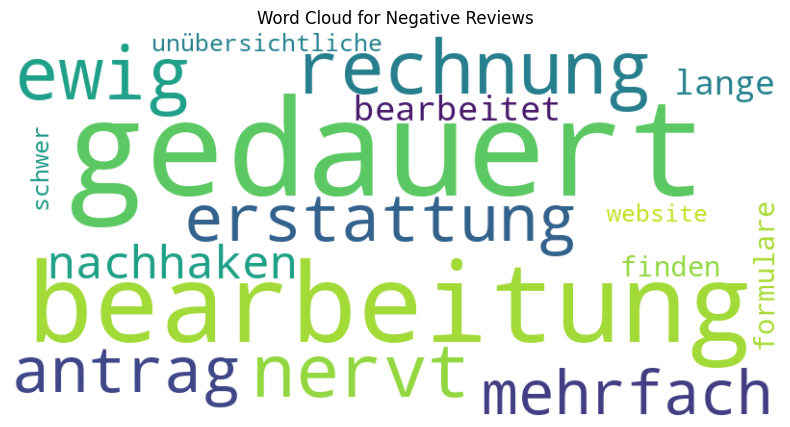

In [36]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter for negative reviews (using the 'Sentiment_Sample' column)
negative_reviews_df = text_df[text_df['Sentiment_Sample'] == 'negative'].copy()

# Combine all top keywords and their scores for negative reviews
negative_keywords = {}
for keyword_list in negative_reviews_df['Top_Keywords']:
    for word, score in keyword_list:
        if word in negative_keywords:
            negative_keywords[word] += score
        else:
            negative_keywords[word] = score

# Generate a word cloud for negative reviews
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(negative_keywords)

# Display the word cloud for negative reviews
plt.figure(figsize=(10, 5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()